In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data import ExprData
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(47907)
random.seed(15213)

In [4]:
name_map = {
    'tpcc': 'TPC-C',
    'tpch': 'TPC-H',
    'twitter': 'Twitter',
    'ycsb': 'YCSB'
}

In [5]:
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(4*len(feature_groups)/3, 4))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):
        curr_labels = [name_map[name] for name in simi_data.wl_names]
        curr_zipped = list(zip(simi_data.wl_groups, curr_labels, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    res3 = X_p[X_p['feature_group'] == 'res_3']
    res3 = res3.sort_values('distance', inplace=False)
    # X_p.drop([root_idx],inplace=True)

    sns.barplot(y="distance", x="feature_group", hue="workload", data=X_p, ax=ax, 
                    palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    if len(feature_groups) == 3:
        plt.legend(bbox_to_anchor=(-0.3, 1, 1.4, 0), loc='lower left', ncol=2, mode="expand")
    else:    
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=3, mode="expand")
    print(title)
    plt.savefig(f'figs/Twitter_{fname}', bbox_inches = 'tight')
    plt.show()

In [6]:
data = ExprData()
data.load_pickle()
data = data.remove_by_wlname(['ycsb', 'xml'])
data = data.fix_tpch()
data_by_sku = data.split_by_sku()

# use for later distinguish btw plan and system metrics
perf_features = data.perf_feature_cols
plan_features = data.plan_feature_cols
all_features = data.feature_cols

feature_group_all = ['plan_3', 'plan_7', 'plan', 'res_3', 'res_5', 'res', 'all_3', 'all_7', 'all']
feature_group_plan = ['plan_3', 'plan_7', 'plan']
feature_group_perf = ['res_3', 'res_5', 'res']

In [7]:
# the result sku_result is a dict with its key the SKU,
# the value a list, the classification accuracy for each f_num
simi_dict = {}

for sku in data_by_sku.keys():
    if 'ter' in sku or 'xml' in sku:
        continue
    curr_data = data_by_sku[sku]
    scaler = ScaleData()
    plan_mtxs, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

    simi_calc = Similarity(curr_data, plan_mtxs, plan_col_ranges, perf_mtxs, perf_col_ranges)
    simi_calc.calc_bined_mtx() # all features
    simi_dict[sku] = simi_calc

### Comparing Feature Sets

In [8]:
# Pick one cpu setting (cpu=16 for example)
simi_calc = simi_dict['cpu16']

In [9]:
method='RFE'
est_name = 'LogisticRegression'

In [10]:
# Use top-k feature from all features
fs = FeatureSelection(simi_calc)

top_3 = fs.select_features(3, method, est_name=est_name, direction=None, feature_type=None)
top_7 = fs.select_features(7, method, est_name=est_name, direction=None, feature_type=None)
plan_top_3 = fs.select_features(3, method, est_name=est_name, direction=None, feature_type='plan')
perf_top_3 = fs.select_features(3, method, est_name=est_name, direction=None, feature_type='perf')
plan_top_7 = fs.select_features(7, method, est_name=est_name, direction=None, feature_type='plan')
perf_top_7 = fs.select_features(5, method, est_name=est_name, direction=None, feature_type='perf')

features_all = [plan_top_3, plan_top_7, plan_features, perf_top_3, perf_top_7, perf_features, top_3, top_7, all_features]
features_plan = [plan_top_3, plan_top_7, plan_features]
features_perf = [perf_top_3, perf_top_7, perf_features]

(27, 27, 29)
(27, 27, 29)
(27, 27, 22)
(27, 27, 7)
(27, 27, 22)
(27, 27, 7)


In [11]:
perf_features

['CPU_UTILIZATION',
 'CPU_EFFECTIVE',
 'MEM_UTILIZATION',
 'IOPS_TOTAL',
 'READ_WRITE_RATIO',
 'LOCK_REQ_ABS',
 'LOCK_WAIT_ABS']

In [12]:
top_3

['LOCK_WAIT_ABS', 'MaxCompileMemory', 'AvgRowSize']

In [13]:
top_7

['LOCK_WAIT_ABS',
 'MaxCompileMemory',
 'AvgRowSize',
 'CachedPlanSize',
 'EstimateIO',
 'MEM_UTILIZATION',
 'LOCK_REQ_ABS']

In [14]:
plan_top_3

['MaxCompileMemory', 'CachedPlanSize', 'AvgRowSize']

In [15]:
plan_top_7

['MaxCompileMemory',
 'CachedPlanSize',
 'AvgRowSize',
 'EstimateIO',
 'StatementSubTreeCost',
 'SerialRequiredMemory',
 'CompileMemory']

In [16]:
perf_top_3

['LOCK_WAIT_ABS', 'MEM_UTILIZATION', 'LOCK_REQ_ABS']

In [17]:
perf_top_7

['LOCK_WAIT_ABS',
 'MEM_UTILIZATION',
 'LOCK_REQ_ABS',
 'CPU_UTILIZATION',
 'CPU_EFFECTIVE']

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def pred_stats(simi_calc, n=1, dependent=True, print_label=False):
    true_labels = simi_calc.data.wl_names
    pred_labels = simi_calc.simi_pred(n, dependent)
    if print_label:
        print(f'True labels: {true_labels}')
        print(f'Pred labels: {pred_labels}')
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    return acc, prec, f1, rec

### TS Norm

Base Workload: twitter, Method: cpu16 Independent.MTS L21 Norm


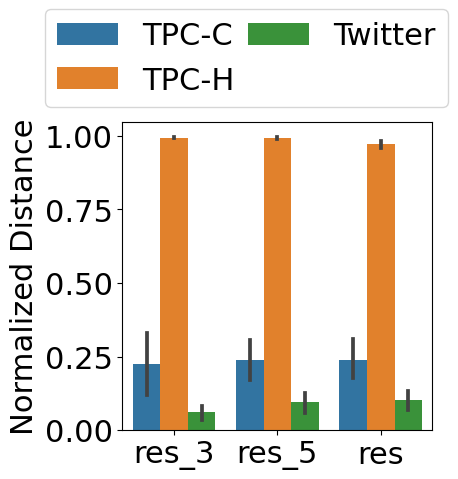

In [19]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
    result_stats = pred_stats(simi_calc, n=1, dependent=True, print_label=False)

plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS L21 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.MTS L11 Norm


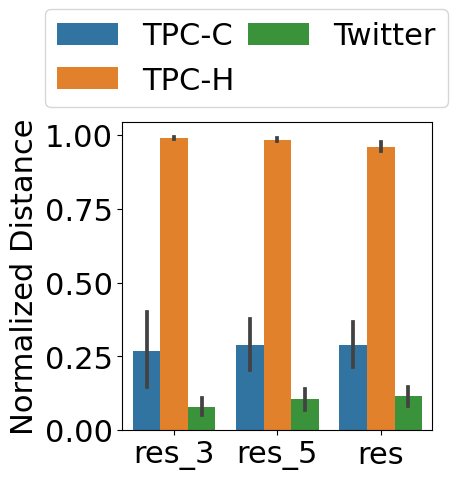

In [20]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS L11 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.MTS Fro Norm


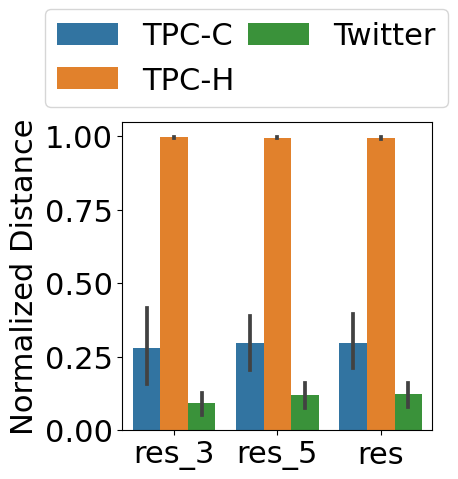

In [21]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Fro Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.MTS Canb Norm


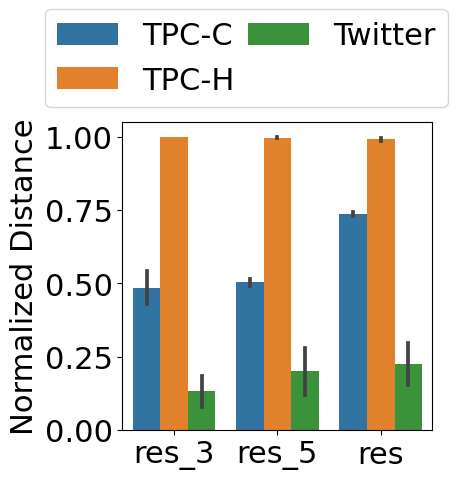

In [22]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Canb Norm', colwise=True, note='')

NAN detected
NAN detected
NAN detected
Base Workload: twitter, Method: cpu16 Independent.MTS Corr Norm


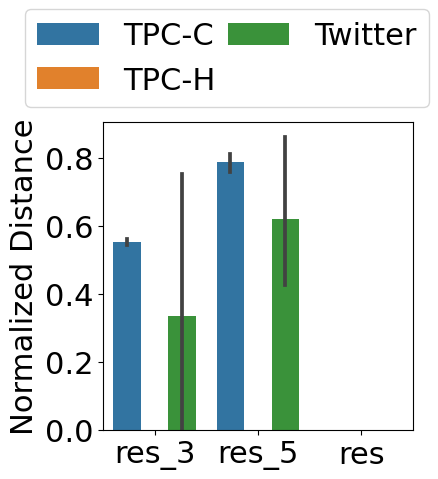

In [23]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Corr Norm', colwise=True, note='')

NAN detected
NAN detected
NAN detected
Base Workload: twitter, Method: cpu16 Independent.MTS Chi2 Norm


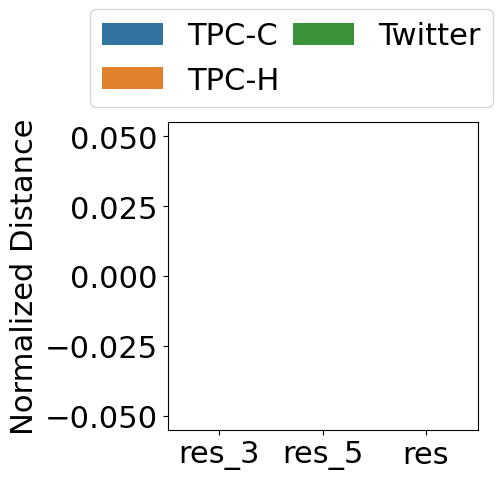

In [24]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_simi_matrix(perf_feature_names=feature_group, normalize=True, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'MTS Chi2 Norm', colwise=True, note='')

In [25]:
'''        
if colwise:
    simi_mtx = simi_calc.simi_col_mtx
else:
    simi_mtx = simi_calc.simi_mtx
'''
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram L21 Norm


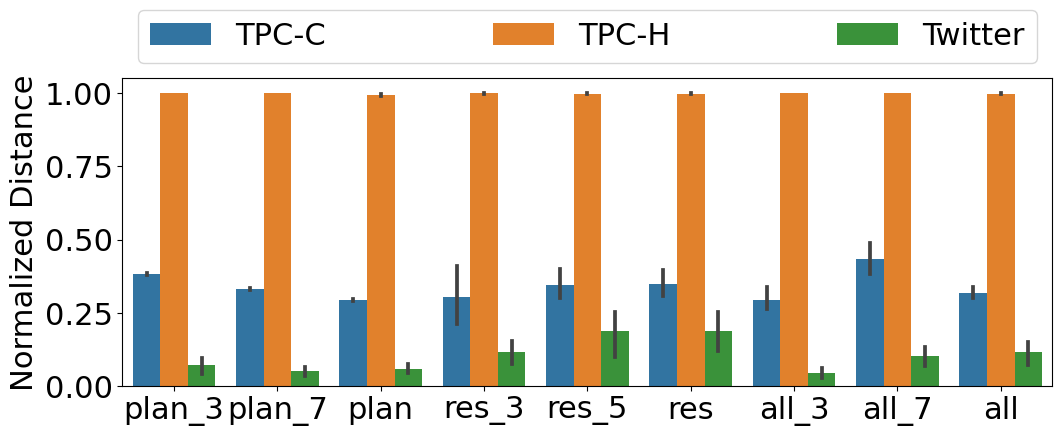

In [26]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram L21 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram L11 Norm


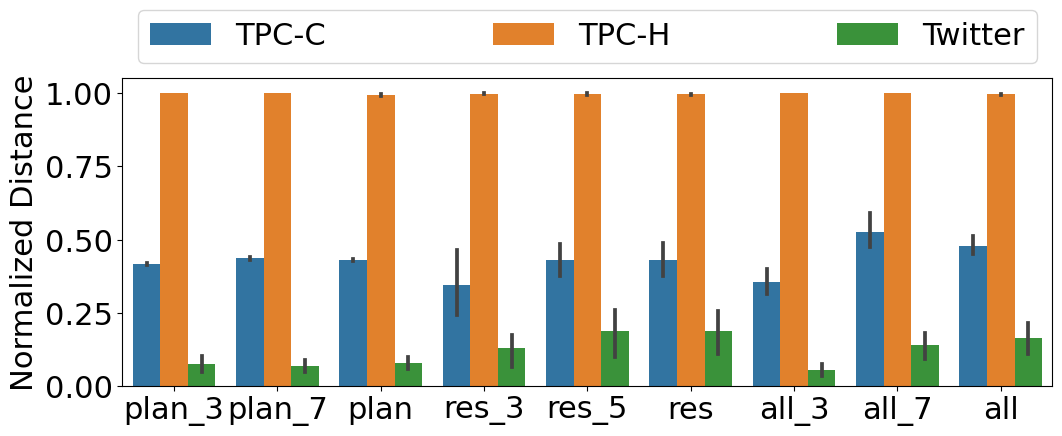

In [27]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram L11 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Fro Norm


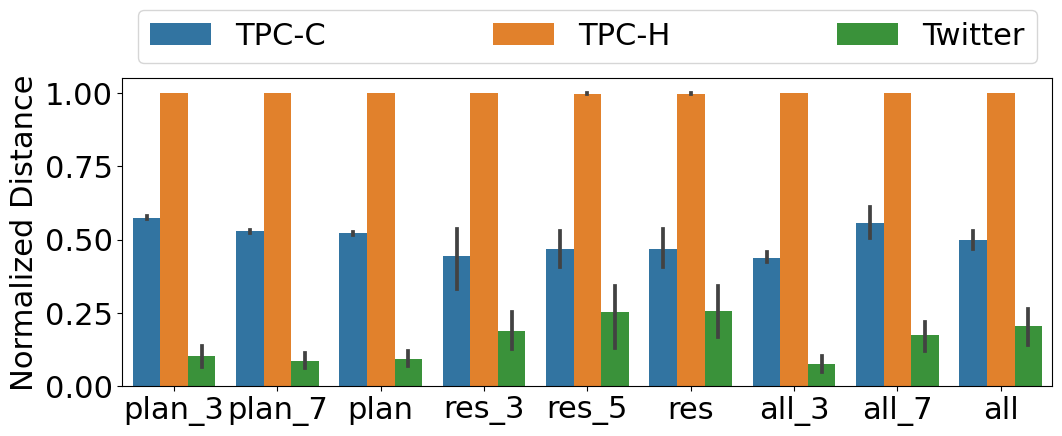

In [28]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Fro Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Canb Norm


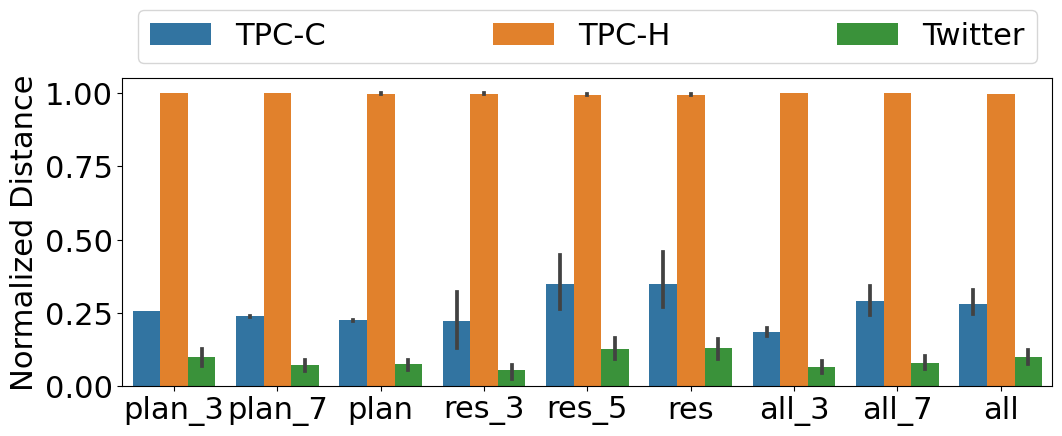

In [29]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Canb Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Chi2 Norm


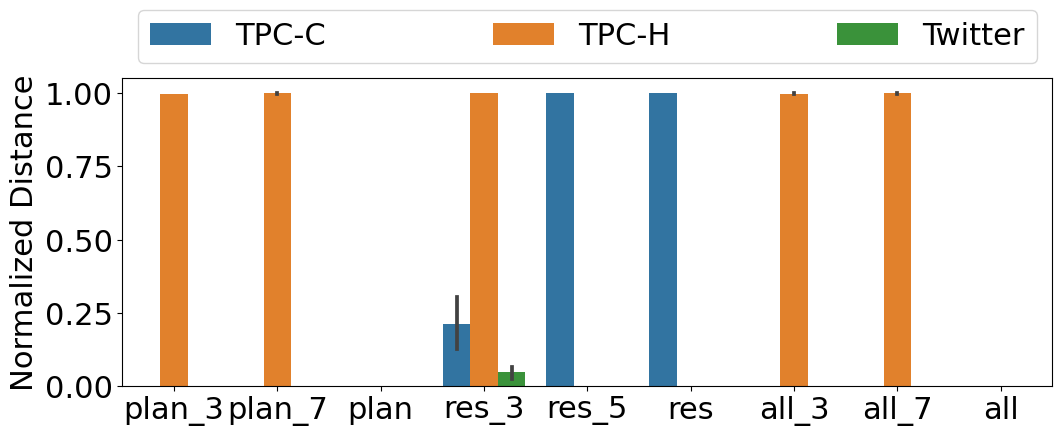

In [30]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Chi2 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Cumulative Histogram Corr Norm


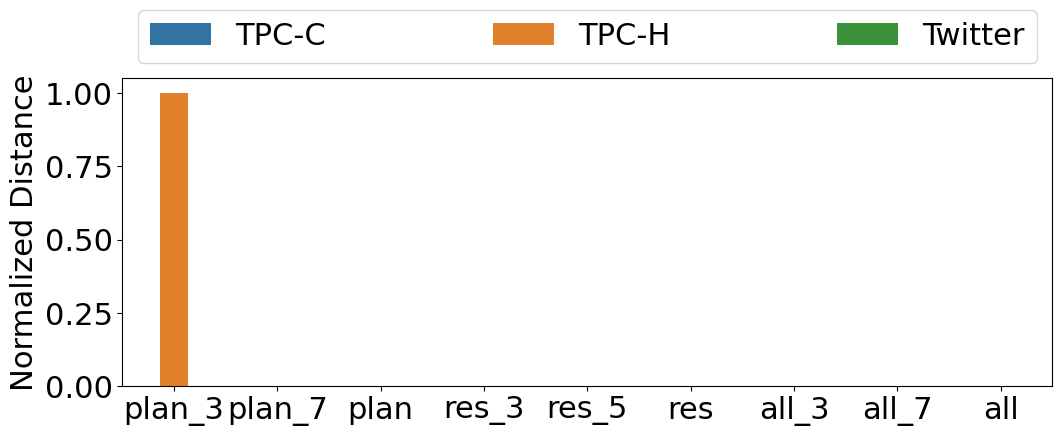

In [31]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, normalize=True, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Cumulative Histogram Corr Norm', colwise=True, note='')

#### Phase Stats FP Distance Measure

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint L21 Norm


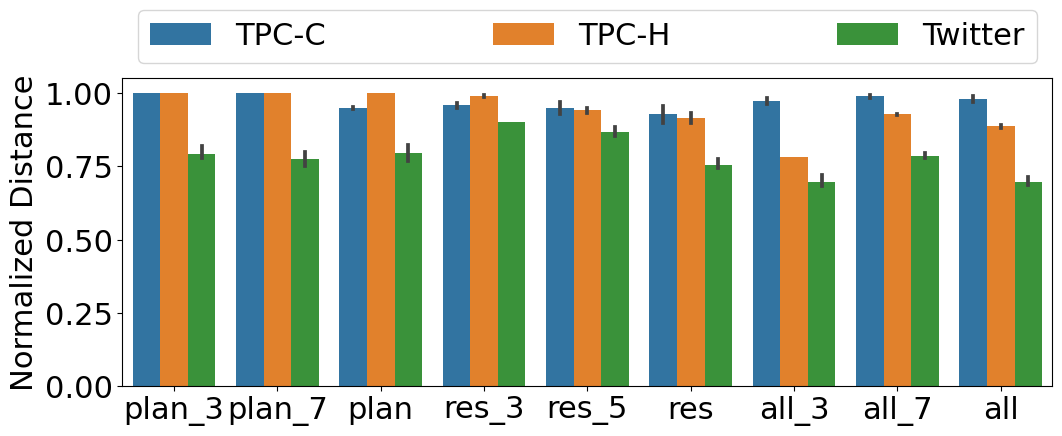

In [32]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='l21')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint L21 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint L11 Norm


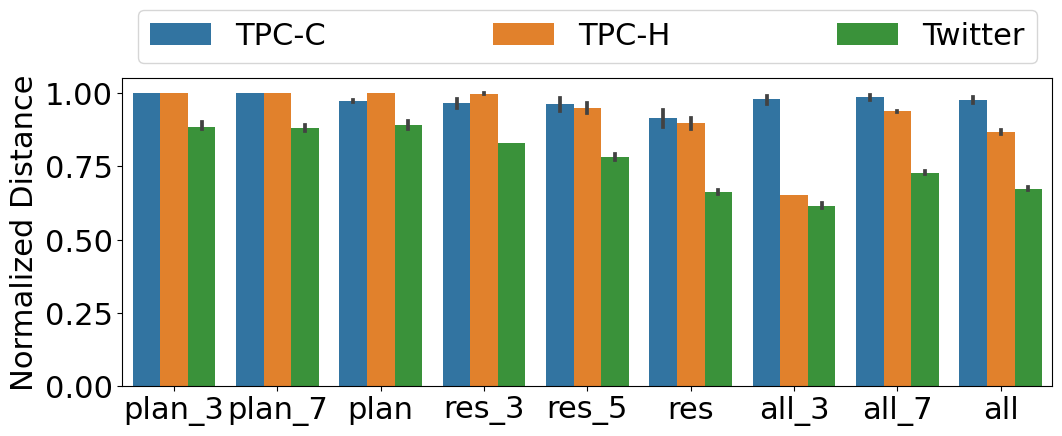

In [33]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='l11')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint L11 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Fro Norm


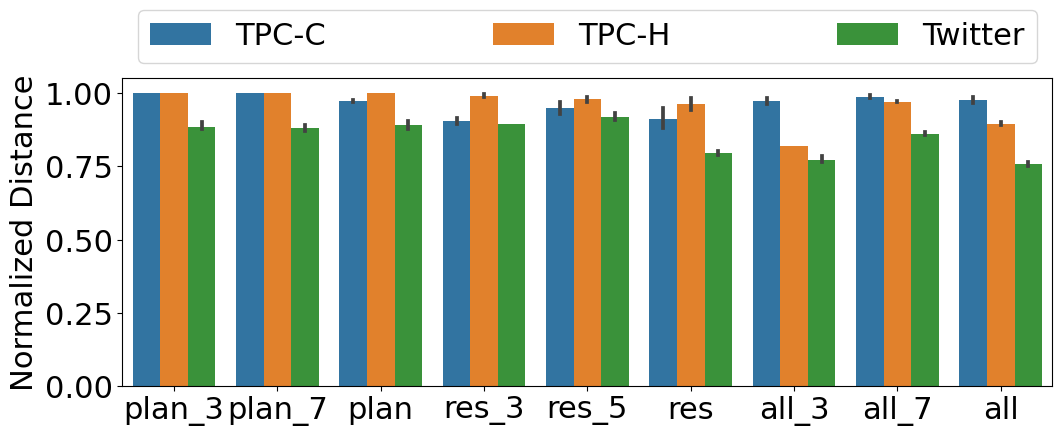

In [34]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='fro')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Fro Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Canb Norm


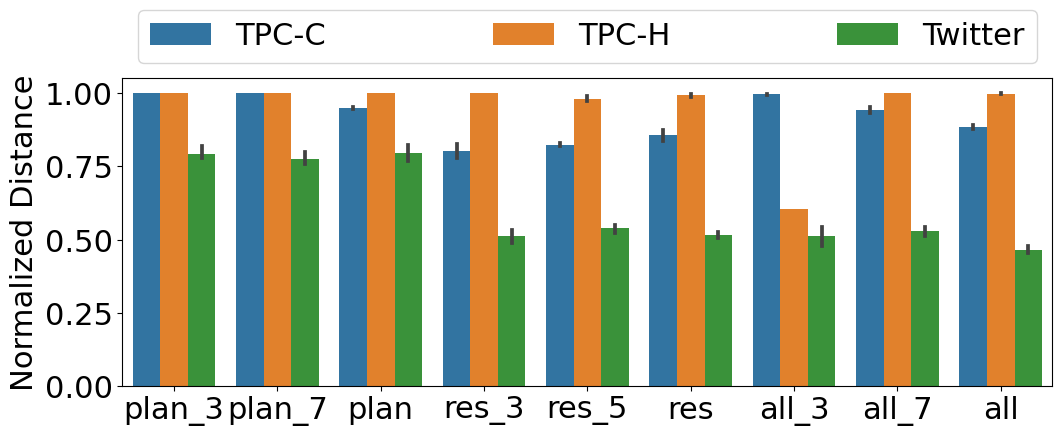

In [35]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='canb')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Canb Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Chi2 Norm


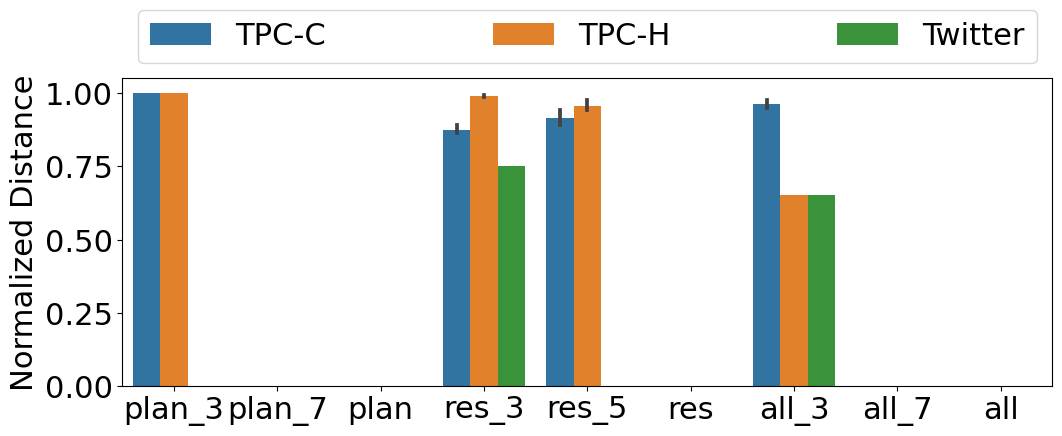

In [36]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='chi2')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Chi2 Norm', colwise=True, note='')

Base Workload: twitter, Method: cpu16 Independent.Phase Fingerprint Corr Norm


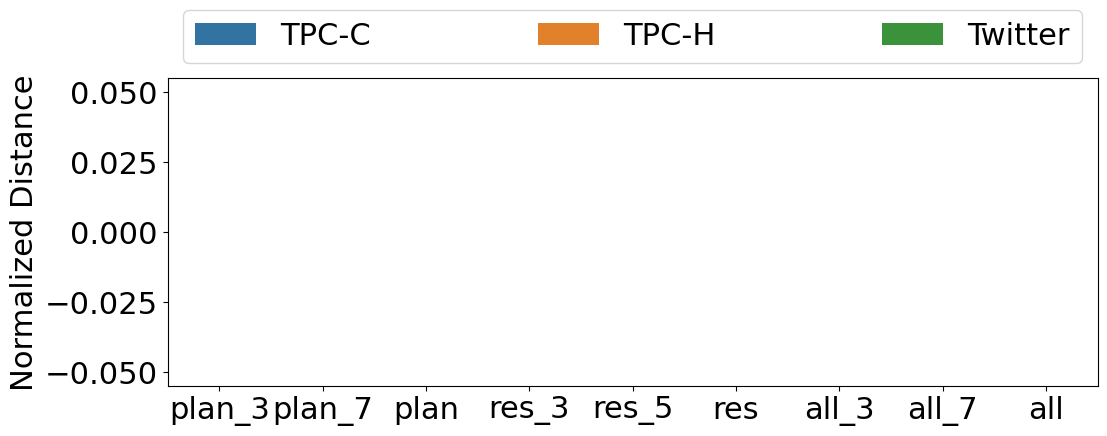

In [37]:
simi_mtxs = []
for feature_group in features_all:
    simi_calc.calc_phase_simi_matrix(feature_names=feature_group, normalize=True, cpd='Kernel', penalty=15, norm_type='corr')
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_all, 20, 'Phase Fingerprint Corr Norm', colwise=True, note='')

#### Dependent DTW

Base Workload: twitter, Method: cpu16 Dependent.Dependent DTW


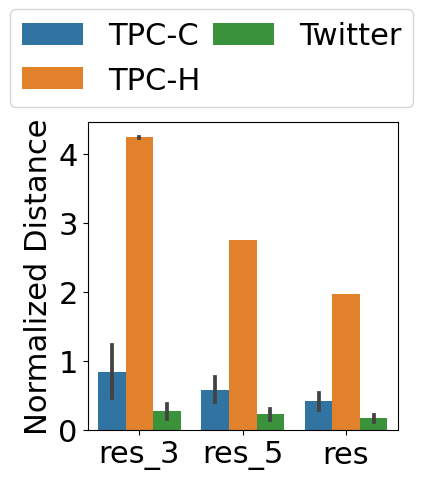

In [38]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Dependent DTW', colwise=False, note='')

#### Independent DTW

Base Workload: twitter, Method: cpu16 Independent.Independent DTW


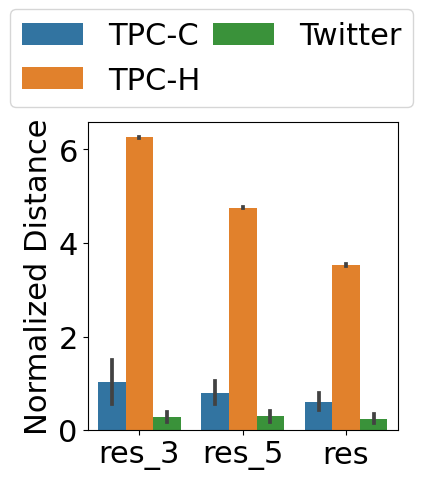

In [39]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_dtw_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Independent DTW', colwise=True, note='')

#### Dependent LCSS

Base Workload: twitter, Method: cpu16 Dependent.Dependent LCSS


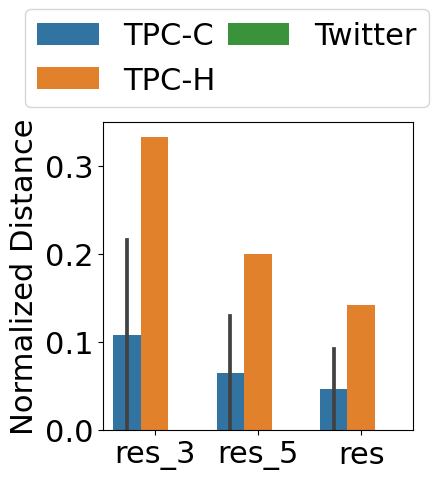

In [40]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Dependent LCSS', colwise=False, note='')

#### Independent LCSS

Base Workload: twitter, Method: cpu16 Independent.Independent LCSS


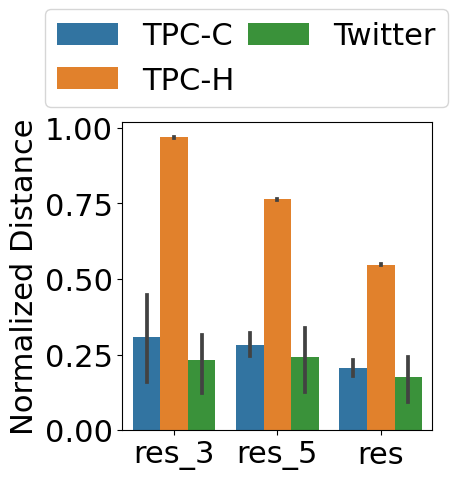

In [41]:
simi_mtxs = []
for feature_group in features_perf:
    simi_calc.calc_ind_lcss_simi_matrix(perf_feature_names=feature_group)
    simi_mtxs.append(simi_calc.simi_col_mtx)
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_perf, 20, 'Independent LCSS', colwise=True, note='')